# Sensitivity analysis programmatically with Sumo - an introductory example

Sumo's core simulator component can be accessed from external programs and can be commanded freely. To make this possible, this core component displays an API which we are going to access here from Python.

To make things a bit more convenivent, we (Dynamita) have developed a Python module that wraps many of these API calls into more convenient calls to support high-level thinking about simulation-oriented tasks.

This simple example shows how to use a previously built Sumo project in Python, and to do a simple parameter sensitivity analysis by repeated parameter changes and simulation runs. To be more specific, we are going to use one batch CSTR (the .sumo file can be found in this same folder), change the ammonia half-saturation coefficient and plot the ammonia concentration vs time for all our tested parameter values. 

As a first step, we import some tools from external modules:

In [1]:
from dynamita.sumo import Sumo, dur

import numpy
import time
import matplotlib.pyplot as plt
%matplotlib notebook

Here below we load Sumo in this environment. The call takes two arguments:

- the first one is the install path of Sumo (to be more precise, the path where the **sumocore.dll** file can be found)
- the second one is the path to the license file

In [2]:
sumo = Sumo(sumoPath="d:/0sw/Sumo19",
           licenseFile=r"d:/0sw/Sumo19/yourlicensefile.sumodyn")

License OK...


This next one will take some explanation of how simulations in Sumo are structured internally:

As a fundamental rule, when the user starts a simulation, Sumo will do the dynamic simulation uninterrupted until the stop time is reached. Communication in general takes place only in data communication intervals (there are a few exceptions, e.g. if we provide dynamic data files then we can influence the simulation even outside data communication intervals, but this does not strictly belong to this basic explanation).

However, Sumo does not know what the user wants to do at data communication intervals, so it leaves for her/him to define the required behavior. This is done by defining a custom function here below. Anything can be inserted in this function; our example makes two queries to the core: the first one is for the current simulation time, the second one is the current ammonia concentration.

The function can be named arbitrarily; the only requirement is that it has to receive the previously created sumo object as its argument.

In [3]:
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
    snhx.append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, 0))
    return 0

In [4]:
def message_callback(sumo):
    for message in sumo.messages:
        print(message)
    sumo.messages = []
    return 0

In [5]:
sumo.register_message_callback(message_callback)

After all these preparations let us load our project. One important side note here is that the parameters modified in the GUI (e.g. in the 'Input setup' mode) will not appear when we load the project from here. The reason is that those modifications are stored in a different file within the .sumo project, but when we load the model from here, we only unpack the .dll file itself.

This will probably change in a future version of the Sumo Python tools but for now all those settings that one might have applied to the GUI, must be repeated here manually via 'set' commands. For further information on how to use the 'set' command, please consult the Sumo documentations.

In [6]:
sumo.load_model('cstr.sumo')

530021 Set: Sumo__StopTime to 0
530021 Set: Sumo__DataComm to 3600000
530021 Set: Sumo__PlantName to d:\0sw\Sumo19\.tmp\rlc2tfye.bgd\sumoproject.xml
530049 Core loop started.

0

This command below lets Sumo know about our custom datacomm function:

In [7]:
sumo.register_datacomm_callback(datacomm_callback)

As we are on our own, we need to find our variables inside the model ourselves. This can be done either by the variable name, or using the fast lane, via the variable's internal position (This is waaay faster. Sumo stores the model variables internally in a table. This position means roughly which row our variable is in.). So here below we retrieve the position of the ammonia concentration.

Oh, and BTW, here are some examples on how to use the 'set' command as well. 

In [8]:
snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__CSTR1__SNHx')
sumo.send_command('set Sumo__Plant__CSTR1__param__XOHO_0 0;')
sumo.send_command('set Sumo__Plant__CSTR1__param__XPAO_0 0;')
sumo.send_command('set Sumo__Plant__CSTR1__param__SNHx_0 5;')

530021 Set: Sumo__Plant__CSTR1__param__XOHO_0 to 0
530021 Set: Sumo__Plant__CSTR1__param__XPAO_0 to 0
530021 Set: Sumo__Plant__CSTR1__param__SNHx_0 to 5


Just to demonstrate that the variable position is indeed only a number:

In [9]:
snhx_pos

19

This below is done in the 'Simulation' mode in the GUI - arguments are taken in msecs:

In [10]:
sumo.set_stopTime(7200000)
sumo.set_dataComm(30000)

530021 Set: Sumo__StopTime to 7200000
530021 Set: Sumo__DataComm to 30000


Let's define some storage space for our simulation results. For the sake of simplicity we use raw Python lists.

In [11]:
t = []
snhx = []

First let's just run one simulation with the default parameter values:

In [12]:
sumo.run_model()

530002 Simulation started.
530004 Simulation ended.


Looking at our previously defined lists we can see that now they are magically filled with the simulation results. 

Actually there is no magic in the process; while Sumo was running the simulation, it called our previously defined *datacomm_callback* function every time it reached the data communication interval which we set by the set_dataComm call above.

In [13]:
snhx

[5.0,
 4.909034129930658,
 4.818304479019445,
 4.727817205750779,
 4.637578314290339,
 4.547593737041543,
 4.457870670566025,
 4.368416378069099,
 4.279238412478769,
 4.190344702207164,
 4.101743597576949,
 4.013443843326506,
 3.9254546985354484,
 3.837785941128058,
 3.7504478566845907,
 3.663451258481501,
 3.5768075281839273,
 3.4905286585127966,
 3.4046272885196873,
 3.319116747416203,
 3.2340110951037424,
 3.149325162970689,
 3.065074600566519,
 2.981275928236134,
 2.8979465929311377,
 2.8151050261233275,
 2.7327707049452354,
 2.6509642177604213,
 2.569707334274065,
 2.489023079751647,
 2.408935813181144,
 2.3294713095422943,
 2.2506568462781145,
 2.172521293771125,
 2.09509520940609,
 2.0184109346880925,
 1.9425026947396626,
 1.8674066992364617,
 1.793161243479298,
 1.7198068078823878,
 1.647386153678592,
 1.5759444120661288,
 1.505529163321717,
 1.4361905015765184,
 1.3679810799946972,
 1.3009561300089973,
 1.2351734457236607,
 1.170693325868593,
 1.1075784671796511,
 1.0458937920

Let's plot our simulation results:

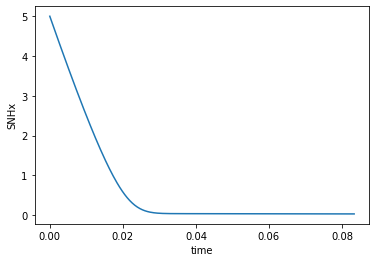

In [14]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('time')
ax.set_ylabel('SNHx')
ax.plot(t, snhx)
fig.canvas.draw()

OK, let's start some serious work now using the tools demonstrated above:

In [15]:
# Let's store all the sensitivity analysis results in one data structure.
from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()

# So we are going to change the ammonia half-saturation coefficient. 
# For now we just create a list of our desired values manually. 
# If required, Python provides tools to create the required values programmatically - see e.g. the range or linspace methods.
for KNHx in [0.2, 0.4, 0.6, 0.8, 1.0]:
    command = 'set Sumo__Plant__param__Sumo1__KNHx_NITO_AS ' + str(KNHx) + ';'
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx = []
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    snhx_sensitivity_data[KNHx] = snhx

530021 Set: Sumo__Plant__param__Sumo1__KNHx_NITO_AS to 0.2
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__param__Sumo1__KNHx_NITO_AS to 0.4
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__param__Sumo1__KNHx_NITO_AS to 0.6
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__param__Sumo1__KNHx_NITO_AS to 0.8
530002 Simulation started.
530004 Simulation ended.
530021 Set: Sumo__Plant__param__Sumo1__KNHx_NITO_AS to 1
530002 Simulation started.
530004 Simulation ended.


...and finally let's plot the results. Nothing really prevents us from updating our plots inside the sensitivity analysis loop either - that way we would get a graphical feedback about the progress; implementing this feature will be a good user exercise... :P

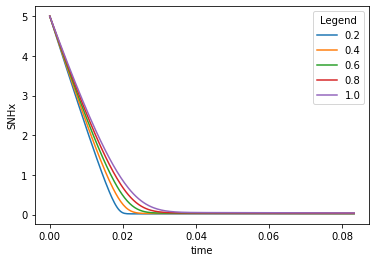

In [16]:
fig, axes = plt.subplots(1,1)
axes.set_xlabel('time')
axes.set_ylabel('SNHx')

for KNHx, snhx in snhx_sensitivity_data.items():
    axes.plot(t, snhx, label=str(KNHx))
    plt.legend(loc='upper right', title='Legend')
    fig.canvas.draw()